<a href="https://colab.research.google.com/github/Sukhdeep2006/Learning-TensorFlow/blob/main/005_TF_TransferLearning_Cats_v_Dogs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Transfer Learning with TensorFlow Hub

** We will use a model from Tensor Flow Hub for predictions.  
** We will use it to classify Cats vs Dogs images.  
** We will understand how the concept of transfer learning helps us.  

In [ ]:
from __future__ import absolute_import, division, print_function

import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_datasets as tfds
from tensorflow.keras import layers

import numpy as np
import PIL.Image as Image

### Download the classifier

 ** We will download the pre trained MobileNet image classification model and reuse it as follows.  

In [ ]:
CLASSIFIR_URL = "https://tfhub.dev/google/tf2-preview/mobilenet_v2/classification/2"
IMAGE_RES = 224

model = tf.keras.Sequential([hub.KerasLayer(CLASSIFIR_URL, input_shape = (IMAGE_RES, IMAGE_RES, 3))])

### Lets run it on a single image

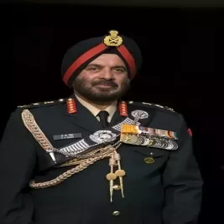

In [ ]:
jj_sing_path = tf.keras.utils.get_file('image_jj.jpg', 'https://qph.fs.quoracdn.net/main-qimg-2eebad216d2b5f4a1c0b09a837833d63.webp')
#jj_sing_path = tf.keras.utils.get_file('image_8.jpg', 'https://i2.wp.com/hipertextual.com/wp-content/uploads/2021/04/Albert-Einstein.jpg?fit=2400%2C1350&ssl=1')

jj_sing = Image.open(jj_sing_path).resize((IMAGE_RES, IMAGE_RES))
jj_sing

In [ ]:
jj_sing =np.array(jj_sing)/255.0


In [ ]:
result  = model.predict(jj_sing[np.newaxis, ...])
#result.shape
predicted_class = np.argmax(result[0], axis = -1)
predicted_class

653

### Decode the predictions

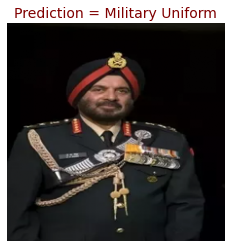

In [ ]:
#labels_path = tf.keras.utils.get_file('ImageNetLabels.txt', 'https://storage.googleapis.com/download.tensorflow.org/data/ImageNetLabels.txt')
labels_path = tf.keras.utils.get_file('ImageNetLabels.txt', 'https://storage.googleapis.com/download.tensorflow.org/data/ImageNetLabels.txt')

imagenet_labels = np.array(open(labels_path).read().splitlines())

plt.imshow(jj_sing)
plt.axis('off')
predicted_class_name = imagenet_labels[predicted_class]
_ = plt.title("Prediction = "+ predicted_class_name.title(), color = 'maroon', size = '14')

In [ ]:
splits = ['train[:80%]', 'train[80%:]']
dataset, metadata = tfds.load('cats_vs_dogs',as_supervised = True, with_info = True, split=splits)
train_dataset = dataset['train']
valid_dataset = dataset['validation']
num_examples = metadata.splits['train'].num_examples
num_classes = metadata.features['label'].num_classes

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/cats_vs_dogs/4.0.0.incompleteSGWM97/cats_vs_dogs-train.tfrecord


  0%|          | 0/23262 [00:00<?, ? examples/s]

Dataset cats_vs_dogs downloaded and prepared to /root/tensorflow_datasets/cats_vs_dogs/4.0.0. Subsequent calls will reuse this data.


In [ ]:
for i, example_image in enumerate(train_dataset.take(5)):
  print('Image {} shape: {} label: {}'.format(i+1, example_image[0].shape, example_image[1]))

Image 1 shape: (262, 350, 3) label: 1
Image 2 shape: (409, 336, 3) label: 1
Image 3 shape: (493, 500, 3) label: 1
Image 4 shape: (375, 500, 3) label: 0
Image 5 shape: (240, 320, 3) label: 1


In [ ]:
def format_image(image, label):
  image = tf.image.resize(image , (IMAGE_RES, IMAGE_RES))/255.0
  return image, label

In [ ]:
train_dataset = train_dataset.map(format_image)
train_batches = train_dataset.shuffle(num_examples//4).batch(32).prefetch(1)

In [ ]:
image_batch, label_batch = next(iter(train_batches.take(1)))
image_batch = image_batch.numpy()
label_batch = label_batch.numpy()

result_batch = model.predict(image_batch)

predicted_class_names = imagenet_labels[np.argmax(result_batch, axis = -1)]
predicted_class_names

array(['Egyptian cat', 'Shetland sheepdog', 'flat-coated retriever',
       'Egyptian cat', 'tabby', 'Chesapeake Bay retriever',
       'Egyptian cat', 'Labrador retriever', 'Egyptian cat', 'kelpie',
       'tabby', 'Bouvier des Flandres', 'Persian cat',
       'Labrador retriever', 'pug', 'lynx', 'Egyptian cat',
       'Egyptian cat', 'Shih-Tzu', 'tabby', 'Gordon setter', 'dishwasher',
       'Egyptian cat', 'American Staffordshire terrier', 'bath towel',
       'tiger cat', 'Shetland sheepdog', 'Rhodesian ridgeback', 'tabby',
       'Labrador retriever', 'tabby', 'Staffordshire bullterrier'],
      dtype='<U30')

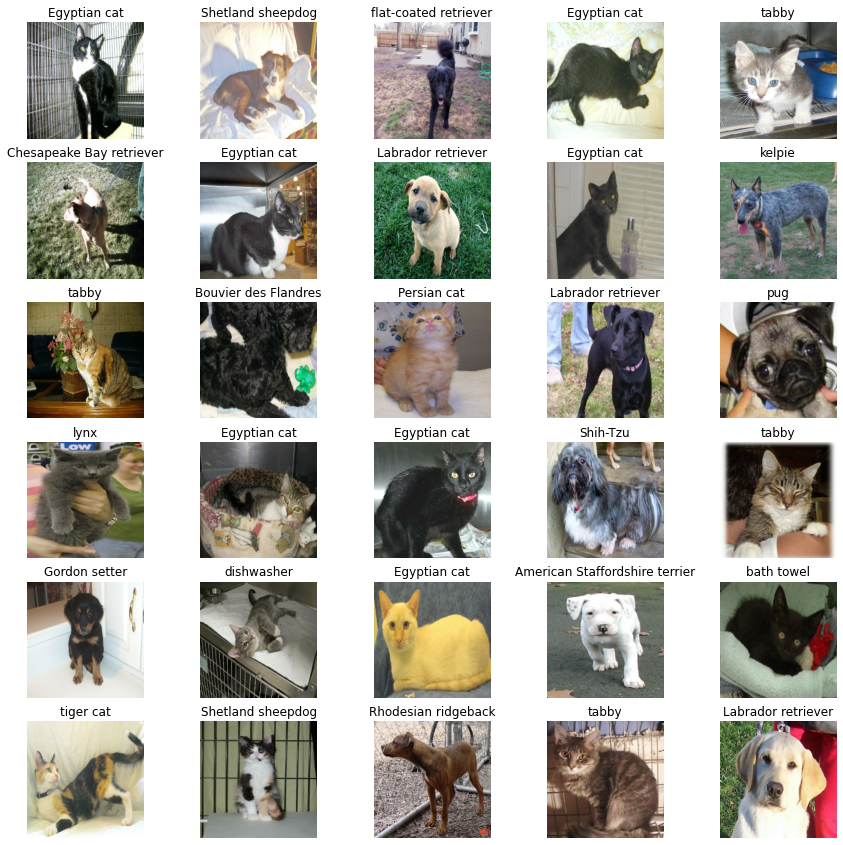

In [ ]:
plt.figure(figsize =(15,15))
for n in range(30):
  plt.subplot(6,5,n+1)
  plt.imshow(image_batch[n])
  plt.title(predicted_class_names[n])
  plt.axis('off')

### Since the MobileNet is trained on ImageNet databse whihc has many species of the dogs in addition to many more objects it is trained on, we see these strange labels we were not expecting.


We would need to retrain this model for the two labels we are expecting


### We will get the feature vector of the images whihc is the output of the second last layer of the mobile net model. This will have more number of outputs than the final labels we get from mobile net. 

In [ ]:
URL = 'https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/2'
feature_extractor = hub.KerasLayer(URL, input_shape = (IMAGE_RES, IMAGE_RES, 3))


In [ ]:
feature_batch = feature_extractor(image_batch)
print(feature_batch.shape)

(32, 1280)


As expected we are getting 1280 number of features instead of 1000.
We need to define the last layer of this model now, in order to get a 2 class identifier.

In [ ]:
feature_extractor.trainable = False

In [ ]:
model = tf.keras.Sequential([
                             feature_extractor,
                             layers.Dense(2,activation = 'softmax')
])

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer_1 (KerasLayer)   (None, 1280)              2257984   
_________________________________________________________________
dense (Dense)                (None, 2)                 2562      
Total params: 2,260,546
Trainable params: 2,562
Non-trainable params: 2,257,984
_________________________________________________________________


### Now that we have defined our model, Lets train it.

In [ ]:
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics= ['accuracy'])
EPOCHS = 6

history = model.fit(train_batches, epochs=EPOCHS)

Epoch 1/6
727/727 [==============================] - 48s 54ms/step - loss: 0.0486 - accuracy: 0.9827
Epoch 2/6
727/727 [==============================] - 45s 54ms/step - loss: 0.0287 - accuracy: 0.9899
Epoch 3/6
727/727 [==============================] - 45s 54ms/step - loss: 0.0248 - accuracy: 0.9920
Epoch 4/6
727/727 [==============================] - 45s 54ms/step - loss: 0.0220 - accuracy: 0.9920
Epoch 5/6
727/727 [==============================] - 45s 54ms/step - loss: 0.0199 - accuracy: 0.9933
Epoch 6/6
727/727 [==============================] - 45s 53ms/step - loss: 0.0178 - accuracy: 0.9939


dict_keys(['loss', 'accuracy'])


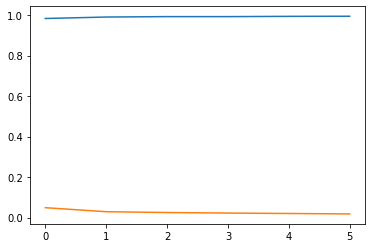

In [ ]:
print(history.history.keys())
accu = history.history['accuracy']
loss = history.history['loss']
epoch_range = range(EPOCHS)

plt.plot(epoch_range, accu, label = 'Accuracy')
plt.plot(epoch_range, loss, label = 'Loss')


In [ ]:
class_names = np.array(metadata.features['label'].names)
predicted_batch = model.predict(image_batch)
predicted_batch = tf.squeeze(predicted_batch).numpy()
predicted_ids = np.argmax(predicted_batch, axis = -1)
predicted_class_names = class_names[predicted_ids]
predicted_class_names

array(['cat', 'dog', 'dog', 'cat', 'cat', 'dog', 'cat', 'dog', 'cat',
       'dog', 'cat', 'dog', 'cat', 'dog', 'dog', 'cat', 'cat', 'cat',
       'dog', 'cat', 'dog', 'cat', 'cat', 'dog', 'cat', 'cat', 'cat',
       'dog', 'cat', 'dog', 'cat', 'dog'], dtype='<U3')

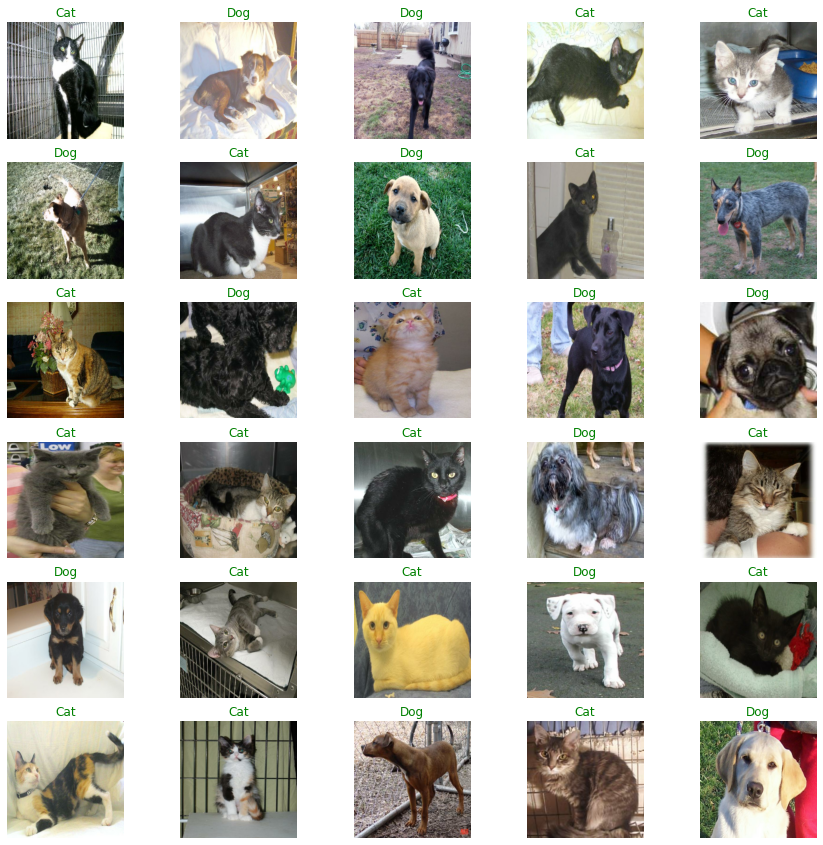

In [ ]:
plt.figure(figsize = (15,15))
for n in range(30):
  plt.subplot(6,5,n+1)
  plt.imshow(image_batch[n])
  color = 'green' if predicted_ids[n] == label_batch[n] else 'red'
  plt.title(predicted_class_names[n].title(), color = color)
  plt.axis('off')
